# **Modello del Discriminatore**

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 443425103176271262, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9785932402853971004
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import torch
import torch.nn as nn

# Layer convolutivo

class Block(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super().__init__()
    self.conv = nn.Sequential(
        # Il padding impostato in "reflect mode" (al posto degli zeri) aiuta ad eliminare gli artefatti dalle immagini
        # Il bias viene impostato a True, in modo che nell'equazione di convoluzione
        # f(x) = w*x + b appaia il termine "b", i cui valori dipendono dal kernel utilizzato.
        nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=True, padding_mode="reflect"),
        nn. InstanceNorm2d(out_channels), # al posto della batch norm, la normalizzazione viene applicata prendendo ogni singolo campione di immagine
        nn.LeakyReLU(0.2, inplace = True),
    )

  def forward(self, x):
    return self.conv(x)

In [ ]:
# Modello del discriminatore completo

class Discriminator(nn.Module):
  # il vettore "features" indica le dimensioni di output di ogni layer convolutivo
  def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
    super().__init__()
    # Il primo layer convolutivo è lo stesso di quello prima creato, 
    # con l'eccezione che non viene applicata la normalizzazione.
    self.initial = nn.Sequential(
        nn.Conv2d(
            in_channels,
            features[0],
            kernel_size = 4,
            stride = 2,
            padding = 1,
            padding_mode = "reflect",
        ),
        nn.LeakyReLU(0.2, inplace=True)
    ) # 256x256x3 --> 128x128x64

    layers = []
    in_channels = features[0]
    # Downsampling path:
    # - 128x128x64 ---> 64x64x128
    # - 64x64x128 ---> 32x32x256
    # - 32x32x256 ---> 31x31x512
    for feature in features[1:]:
      # Stride = 1 solo per l'ultimo layer
      layers.append(Block(in_channels, feature, stride = 1 if feature == features[-1] else 2))
      in_channels = feature # Nuova dimensione per l'input del successivo layer
    # Aggiungiamo alla fine un layer convolutivo che serve a
    # trasformare l'immagine da 512 --> 1 feature per la classificazione:
    # 31x31x512 ---> 30x30x1
    layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
    self.model = nn.Sequential(*layers) # unwrap della lista all'interno del layer sequenziale


  def forward(self, x):
    x = self.initial(x)
    # Applichiamo la sigmoide perchè l'output del discriminatore deve essere 
    # tra 0 ed 1.
    return torch.sigmoid(self.model(x)) 






In [ ]:
# Test per il discriminatore
def test_disc():
  x = torch.randn((5, 3, 256, 256)) # 5 campioni di immagini 256*256 RGB
  model = Discriminator(in_channels = 3)
  preds = model(x)
  print(model)
  print(preds.shape) # 5x1x30x30 --> si applica una PatchGAN che valuta porzioni di 30x30 pixel nell'immagine

test_disc()

Discriminator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): Block(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): Block(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): Block(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
        (1

In [ ]:
# Test per verificare la dimensione dell'output ad ogni layer
#l1 = nn.Sequential(
        #nn.Conv2d(
            #512,
            #1,
           # kernel_size = 4,
           # stride = 1,
           # padding = 1,
           # padding_mode = "reflect",
        #),
        #nn. InstanceNorm2d(512),
        #nn.LeakyReLU(0.2, inplace=True)
   # )
#x = torch.randn((5, 512, 31, 31)) 
#preds = torch.sigmoid(l1(x))
#print(preds.shape)

torch.Size([5, 1, 30, 30])


# **Modello del Generatore**

In [ ]:
# Definisco i layer convolutivi standard e trasposti da utilizzarsi per il generatore

class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, down = True, use_activations = True, **kwargs):
    super().__init__()
    self.conv = nn.Sequential(
        # kwargs contiene i parametri di kernel, stride e padding
        nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
        if down
        else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
        nn.InstanceNorm2d(out_channels),
        # Se si usa una funzione di attivazione si inserisce la ReLU,
        # altrimenti si inserisce la funzione identità
        nn.ReLU(inplace = True) if use_activations else nn.Identity()
    )

  def forward(self, x):
    return self.conv(x)

In [ ]:
# Definisco il modello per un Residual Block

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.block = nn.Sequential(
        ConvBlock(channels, channels, kernel_size = 3, padding = 1, stride = 1),
        # Non uso la funzione di attivazione
        ConvBlock(channels, channels, use_activations = False, kernel_size = 3, padding = 1, stride = 1)
    )

  def forward(self, x):
    return x + self.block(x)

In [ ]:
# Modello del generatore

class Generator(nn.Module):
  # Il numero di blocchi residui di default è pari a 9,
  # ciò ha senso quando l'immagine in input è di dimensioni 256x256 o maggiori,
  # altrimenti per immagini di dimensione 128x128 o minori in genere si 
  # utilizzano 6 blocchi residui.
  def __init__(self, img_channels, num_features = 64, num_residuals = 9):
    super().__init__()
    # Il primo layer non utilizza la normalizzazione
    self.initial = nn.Sequential(
        nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
        nn.ReLU(inplace=True),
    )
    # downsampling path
    self.down_blocks = nn.ModuleList(
        [
         ConvBlock(num_features, num_features*2, kernel_size = 3, stride = 2, padding = 1),
         ConvBlock(num_features*2, num_features*4, kernel_size = 3, stride = 2, padding = 1),
        ]
    )

    self.residual_blocks = nn.Sequential(
        # Unwrap dei blocchi, 9 in totale
        *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
    )

    # upsampling path
    self.up_blocks = nn.ModuleList(
        [
         # Il parametro di output_padding aggiunge un ulteriore padding all'output del layer (come mostrato dagli autori)
         ConvBlock(num_features*4, num_features*2, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
         ConvBlock(num_features*2, num_features, down = False, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
        ]
    )

    # Ultimo layer convolutivo che mappa la feature map in un'immagine RGB (3 canali)
    self.last = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

  def forward(self, x):
    x = self.initial(x)
    for layer in self.down_blocks:
      x = layer(x)
    x = self.residual_blocks(x)
    for layer in self.up_blocks:
      x = layer(x)
    return torch.tanh(self.last(x)) # I valori dei pixel variano tra -1 ed 1

In [ ]:
# test dimensioni
#num_features = 64
#layer =  nn.Conv2d(num_features, 3, kernel_size=7, stride=1, padding=3, padding_mode="reflect")
#x = torch.randn((1, 64, 256, 256)) 
#out = layer(x)
#print(out.shape)

torch.Size([1, 3, 256, 256])


In [ ]:
# Test per il generatore

def test_gen():
  img_channels = 3
  img_size = 256
  x = torch.randn((2, img_channels, img_size, img_size))
  gen = Generator(img_channels, 9)
  print(gen)
  print(gen(x).shape) # 3x256x256, la stessa dimensione dell'immagine in input

test_gen()

Generator(
  (initial): Sequential(
    (0): Conv2d(3, 9, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (down_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(9, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(18, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(18, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(36, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (conv): Sequential(
            (0): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), pa

# **Caricamento del dataset**

In [ ]:
!pip install -U albumentations==0.4.6

     |████████████████████████████████| 122kB 8.8MB/s 
     |████████████████████████████████| 952kB 40.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=a8c30c63f5982c7dbce82f3b18ae3657bab549959eebd15366f8e34f8193deae
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np

class SummerWinterDataset(Dataset):
    def __init__(self, root_summer, root_winter, transform=None):
        self.root_summer = root_summer
        self.root_winter = root_winter
        self.transform = transform

        self.summer_images = os.listdir(root_summer)
        self.winter_images = os.listdir(root_winter)
        self.length_dataset = max(len(self.summer_images), len(self.winter_images)) # massima lunghezza
        self.summer_len = len(self.summer_images)
        self.winter_len = len(self.winter_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        summer_img = self.summer_images[index % self.summer_len]
        winter_img = self.winter_images[index % self.winter_len]

        summer_path = os.path.join(self.root_summer, summer_img)
        winter_path = os.path.join(self.root_winter, winter_img)

        summer_img = np.array(Image.open(summer_path).convert("RGB"))
        winter_img = np.array(Image.open(winter_path).convert("RGB"))

        if self.transform:
          # Applichiamo le trasformazioni
            augmentations = self.transform(image=summer_img, image0=winter_img)
            summer_img = augmentations["image"]
            winter_img = augmentations["image0"]

        return summer_img, winter_img

# **Training**

In [ ]:
import sys
!cp drive/MyDrive/config.py .
import config
!cp drive/MyDrive/utils.py .
from utils import save_checkpoint, load_checkpoint
import torch.optim as optim
from tqdm import tqdm # Progress bar
from torchvision.utils import save_image

def train(disc_summer, disc_winter, gen_winter, gen_summer, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
  summer_reals = 0
  summer_fakes = 0
  if not os.path.exists("saved_images"):
      os.mkdir("saved_images")
  
  loop = tqdm(loader, leave = True)
  
  for idx, (summer, winter) in enumerate(loop):
    summer = summer.to(config.DEVICE)
    winter = winter.to(config.DEVICE)

    # Train per i discriminatori
    with torch.cuda.amp.autocast(): # per il casting a float16
        # Generiamo un'immagine di summer
        fake_summer = gen_summer(winter)
        # Utilizziamo il discriminatore passando l'immagine reale e quella generata
        D_summer_real = disc_summer(summer)
        D_summer_fake = disc_summer(fake_summer.detach())
        summer_reals += D_summer_real.mean().item()
        summer_fakes += D_summer_fake.mean().item()
        # Calcoliamo gli errori
        D_summer_real_loss = mse(D_summer_real, torch.ones_like(D_summer_real)) # Input reali
        D_summer_fake_loss = mse(D_summer_fake, torch.zeros_like(D_summer_fake)) # Input generati
        # Sommiamo gli errori
        D_summer_loss = D_summer_real_loss + D_summer_fake_loss

        # Ripetiamo gli stessi passi per le immagini di winter
        fake_winter = gen_winter(summer)
        D_winter_real = disc_winter(winter)
        D_winter_fake = disc_winter(fake_winter.detach())
        D_winter_real_loss = mse(D_winter_real, torch.ones_like(D_winter_real))
        D_winter_fake_loss = mse(D_winter_fake, torch.zeros_like(D_winter_fake))
        D_winter_loss = D_winter_real_loss + D_winter_fake_loss

        # Uniamo le funzioni di loss e dividiamo per 2 (come fatto dagli autori)
        # in modo da pesare maggiormente i parametri dei generatori.
        D_loss = (D_summer_loss + D_winter_loss)/2
    
    # Calcolo dei gradienti e aggiornamento dei parametri
    opt_disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()


    # Train per i generatori
    with torch.cuda.amp.autocast():
        # Calcoliamo l'adversarial loss per entrambi i generatori
        D_summer_fake = disc_summer(fake_summer)
        D_winter_fake = disc_winter(fake_winter)
        # Le valutazioni dei discriminatori devono essere confrontate con i valori "1"
        # in questo caso, poichè vogliamo che il generatore impari a creare
        # immagini che sembrino reali.
        loss_G_summer = mse(D_summer_fake, torch.ones_like(D_summer_fake))
        loss_G_winter = mse(D_winter_fake, torch.ones_like(D_winter_fake))

        # Cycle consistency loss
        # Generiamo le immagini di partenza (originali) a
        # partire da quelle create (fake)
        cycle_winter = gen_winter(fake_summer)
        cycle_summer = gen_summer(fake_winter)
        # Valutiamo le differenze tra l'immagine reale e quella generata
        cycle_winter_loss = l1(winter, cycle_winter)
        cycle_summer_loss = l1(summer, cycle_summer)

        # Identity loss (remove these for efficiency if you set lambda_identity=0)
        # Generiamo delle immagini a partire da quelle target (es. summer --> summer),
        # in modo da verificare se i generatori modificano la colorazione originale.
        #identity_winter = gen_winter(winter)
        #identity_summer = gen_summer(summer)
        # Anche in questo caso vogliamo che le immagini confontate siano
        # pressochè identiche.
        #identity_winter_loss = l1(winter, identity_winter)
        #identity_summer_loss = l1(summer, identity_summer)

        # Sommiamo i vari contributi
        G_loss = (
            loss_G_winter
            + loss_G_summer
            + cycle_winter_loss * config.LAMBDA_CYCLE # lambda = 10
            + cycle_summer_loss * config.LAMBDA_CYCLE
            #+ identity_summer_loss * config.LAMBDA_IDENTITY
            #+ identity_winter_loss * config.LAMBDA_IDENTITY
        )
    
    # Step
    opt_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()

    # Salviamo alcune immagini generate (si utilizza sempre il training set)
    if idx % 200 == 0:
        save_image(fake_summer*0.5+0.5, f"saved_images/summer_{idx}.png")
        save_image(fake_winter*0.5+0.5, f"saved_images/winter_{idx}.png")
    
    
    #loop.set_postfix(summer_real=summer_reals/(idx+1), summer_fake=summer_fakes/(idx+1))


In [ ]:
def main():
  
  # Creazione discriminatori e generatori
  disc_summer = Discriminator(in_channels=3).to(config.DEVICE)
  disc_winter = Discriminator(in_channels=3).to(config.DEVICE)
  gen_summer = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)
  gen_winter = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)

  # Optimizers
  opt_disc = optim.Adam(
      list(disc_summer.parameters()) + list(disc_winter.parameters()),
      lr=config.LEARNING_RATE, # 0.0002 (come da paper)
      betas=(0.5, 0.999), # momentum e beta2 (come da paper)
  )

  opt_gen = optim.Adam(
      list(gen_summer.parameters()) + list(gen_winter.parameters()),
      lr=config.LEARNING_RATE,
      betas=(0.5, 0.999),
  )

  # Loss functions
  L1 = nn.L1Loss() # Utilizzata per il calcolo della cycle consistency loss e per la identity loss
  mse = nn.MSELoss() # Utilizzata per l'adversarial loss

  # Se ho settato un checkpoint carico i modelli già allenati
  if config.LOAD_MODEL:
      load_checkpoint(
          config.CHECKPOINT_GEN_SUMMER, gen_summer, opt_gen, config.LEARNING_RATE,
      )
      load_checkpoint(
          config.CHECKPOINT_GEN_WINTER, gen_winter, opt_gen, config.LEARNING_RATE,
      )
      load_checkpoint(
          config.CHECKPOINT_DISC_SUMMER, disc_summer, opt_disc, config.LEARNING_RATE,
      )
      load_checkpoint(
          config.CHECKPOINT_DISC_WINTER, disc_winter, opt_disc, config.LEARNING_RATE,
      )

  # Creazione del dataset
  dataset = SummerWinterDataset(
      root_summer=config.TRAIN_DIR+"/summer", root_winter=config.TRAIN_DIR+"/winter", 
      transform=config.transforms)
  val_dataset = SummerWinterDataset(
      root_summer=config.VAL_DIR+"/summer", root_winter=config.VAL_DIR+"/winter", 
      transform=config.transforms)

  # Data Loaders
  val_loader = DataLoader(
      val_dataset,
      batch_size=1,
      shuffle=False,
      pin_memory=True,
  )
  loader = DataLoader(
      dataset,
      batch_size=config.BATCH_SIZE,
      shuffle=True,
      num_workers=config.NUM_WORKERS,
      pin_memory=True
  )

  # Servono per la conversione da float32 a float16 in modo da velocizzare il training
  g_scaler = torch.cuda.amp.GradScaler()
  d_scaler = torch.cuda.amp.GradScaler()

  # Training
  for epoch in range(config.NUM_EPOCHS):
      print("Epoca numero ", epoch)
      train(disc_summer, disc_winter, gen_winter, gen_summer, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

      # Salviamo il modello ad ogni epoca se necessario
      if config.SAVE_MODEL:
          save_checkpoint(gen_summer, opt_gen, filename=config.CHECKPOINT_GEN_SUMMER)
          save_checkpoint(gen_winter, opt_gen, filename=config.CHECKPOINT_GEN_WINTER)
          save_checkpoint(disc_summer, opt_disc, filename=config.CHECKPOINT_DISC_SUMMER)
          save_checkpoint(disc_winter, opt_disc, filename=config.CHECKPOINT_DISC_WINTER)

In [ ]:
main()

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  0


100%|██████████| 1231/1231 [09:51<00:00,  2.08it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  1


100%|██████████| 1231/1231 [09:57<00:00,  2.06it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  2


100%|██████████| 1231/1231 [09:55<00:00,  2.07it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  3


100%|██████████| 1231/1231 [09:56<00:00,  2.06it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  4


100%|██████████| 1231/1231 [09:56<00:00,  2.06it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  5


100%|██████████| 1231/1231 [09:56<00:00,  2.06it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  6


100%|██████████| 1231/1231 [09:57<00:00,  2.06it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  7


100%|██████████| 1231/1231 [09:57<00:00,  2.06it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  8


100%|██████████| 1231/1231 [09:55<00:00,  2.07it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  9


100%|██████████| 1231/1231 [09:56<00:00,  2.06it/s]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/1231 [00:00<?, ?it/s]

Epoca numero  10


  1%|          | 8/1231 [00:04<10:29,  1.94it/s]

KeyboardInterrupt: ignored

In [ ]:
#val_dataset = SummerWinterDataset(
      #root_summer=config.VAL_DIR+"/summer", root_winter=config.VAL_DIR+"/winter", 
      #transform=config.transforms)
#val_loader = DataLoader(
      #val_dataset,
      #batch_size=1,
      #shuffle=False,
      #pin_memory=True,
  #)

In [ ]:
#gen_summer = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)
#gen_winter = Generator(img_channels=3, num_residuals=9).to(config.DEVICE)

=> Loading checkpoint


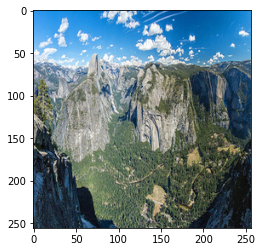

In [ ]:
#import matplotlib.pyplot as plt
#image = (val_loader.dataset[5][0]*0.5+0.5)
#plt.imshow(image.permute(1, 2, 0))
#opt_gen = optim.Adam(
      #list(gen_summer.parameters()) + list(gen_winter.parameters()),
      #lr=config.LEARNING_RATE,
      #betas=(0.5, 0.999),
  #)
#load_checkpoint(
          #config.CHECKPOINT_GEN_WINTER, gen_winter, opt_gen, config.LEARNING_RATE,
      #)